## PGAE for 1D MT inversion
### Created on Oct 1st 2019
### Lian Liu: lianliu1017@126.com

### 1. import modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tensorflow.keras import models, layers, Input, Model, regularizers
import sys
sys.path.append(r'/work/ess-liul/Geophysics/MTPGAE')
from MT1D_fwd import mt1d_analytic, mt1d_analytic_tensor
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2024-11-10 17:12:58.661063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. design neural networks

#### 2.1 define loss function

In [2]:
def custom_loss(y_true, y_pred):
    custom_loss = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(y_true - y_pred), 1), 0)
    
    return custom_loss

In [3]:
class roughness(tf.keras.regularizers.Regularizer):
    def __init__(self, l2 = 0.):  # pylint: disable = redefined-outer-name 
        self.l2 = l2 
 
    def __call__(self, x):
        return self.l2 * tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(x[:, 1:] - x[:, :-1]), 1), 0)
        
    def get_config(self):
        return {'l2': float(self.l2)}

#### 2.2 define earlystopping condition

In [4]:
from tensorflow.keras.callbacks import Callback
class earlystoppingbyloss(Callback):
    def __init__(self, monitor = 'loss', value = 0.006, verbose = 0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs = {}):
        current = logs.get(self.monitor)
        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

#### 2.3 define MT network 

In [5]:
def MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, rough):
    model = models.Sequential()
    model.add(layers.Dense(500, 
                            activation = 'relu', # softplus
                            use_bias = True, 
                            kernel_initializer = tf.constant_initializer(weight_dense1), 
                            bias_initializer = tf.constant_initializer(bias_Dense1), 
                           
                            name = 'dense1', 
                            input_shape = (input_size, )))
    
    # model.add(tf.keras.layers.BatchNormalization())
    # model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(geomodel_size, 
                           # activation = 'relu', 
                           use_bias = True, 
                           kernel_initializer = tf.constant_initializer(weight_geomodel), 
                           bias_initializer = tf.constant_initializer(bias_geomodel), 
                           
                           activity_regularizer = roughness(rough), 
                           
                           name = 'geomodel'))
    
    model.add(layers.Lambda(lambda x: mt1d_analytic_tensor(x)))

    return model

### 3. plot training loss

In [6]:
# note: used for synthetic data
def plot_loss(history):
    fig = plt.figure(figsize = (3, 3))
    ax = plt.axes([0.25, 0.25, 0.75, 0.75])
    
    # plt.semilogy(history.history['loss'], linewidth = 2.)
    # plt.semilogy(history.history['val_loss'], linewidth = 2.)
    
    plt.plot(history.history['loss'], linewidth = 2.)
    plt.plot(history.history['val_loss'], linewidth = 2.)
    plt.ylabel('$\Phi$', fontsize = 12)
    plt.xlabel('Epoch', fontsize = 12)
    # plt.xticks(fontsize = 10.5)
    plt.yticks(fontsize = 10.5)
    plt.xticks(np.linspace(0, 20, 5), fontsize = 10.5)
    ax.legend(['Training', 'Evaluation'], loc = 'best', fontsize = 10)
    # plt.savefig('phi.tiff', dpi = 300, format = 'tiff')
    plt.show()
    
    fig = plt.figure(figsize = (3, 3))
    ax = plt.axes([0.25, 0.25, 0.75, 0.75])
    plt.plot(history.history['custom_loss'], linewidth = 2.)
    plt.plot(history.history['val_custom_loss'], linewidth = 2.)
    plt.ylabel('$\Phi$' + '(d)', fontsize = 12)
    plt.xlabel('Epoch', fontsize = 12)
    # plt.xticks(fontsize = 10.5)
    plt.yticks(fontsize = 10.5)
    plt.xticks(np.linspace(0, 20, 5), fontsize = 10.5)
    ax.legend(['Training', 'Evaluation'], loc = 'best', fontsize = 10)
    # plt.savefig('phi_d.tiff', dpi = 300, format = 'tiff')
    plt.show()
    
    fig = plt.figure(figsize = (3, 3))
    ax = plt.axes([0.25, 0.25, 0.75, 0.75])
    plt.plot((np.array(history.history['loss']) - np.array(history.history['custom_loss'])) / 4.5, linewidth = 2.)
    plt.plot((np.array(history.history['val_loss']) - np.array(history.history['val_custom_loss'])) / 4.5, linewidth = 2.)
    plt.ylabel('$\Phi$' + '(m)', fontsize = 12)
    plt.xlabel('Epoch', fontsize = 12)
    # plt.xticks(fontsize = 10.5)
    plt.yticks(fontsize = 10.5)
    plt.xticks(np.linspace(0, 20, 5), fontsize = 10.5)
    # plt.ticklabel_format(axis = 'y', style = 'sci')
    ax.legend(['Training', 'Evaluation'], loc = 'best', fontsize = 10)
    # plt.savefig('phi_m.tiff', dpi = 300, format = 'tiff')
    plt.show()

### 4. ANN inversion

#### 4.1 training

In [7]:
def main_train(x_train, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, epochs, batch_size, rough = 1e-10, permission_value = 1e-5):
    input_size = x_train.shape[1]
    
    model = MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, rough)
    model.summary()
    model.compile(optimizer = 'adam', loss = custom_loss, metrics = custom_loss)
    
    callbacks = [
            earlystoppingbyloss(monitor = 'loss', value = permission_value, verbose = 0)]
    
    start = time()
    history = model.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, callbacks = callbacks, validation_split = 1. / 6.)
    print(time()-start)
    
    weight_dense1, bias_Dense1 = model.get_layer('dense1').get_weights()
    weight_geomodel, bias_geomodel = model.get_layer('geomodel').get_weights()
    
    return history, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel

#### 4.2 evaluation

In [8]:
def main_eval(x_train, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, batch_size, rough):
    input_size = x_train.shape[1]
    
    model = MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, rough)
    model.compile(optimizer = 'adam', loss = custom_loss, metrics = custom_loss)
    # model.summary()
    
    # start = time()
    history_eval = model.evaluate(x_train, x_train, batch_size = batch_size, verbose = 0, return_dict = False)
    # print(time()-start)
    
    return history_eval

#### 4.3 prediction

In [9]:
def main_predict(x_pred, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, rough = 1e-3):
    input_size = x_pred.shape[1]
    
    model = MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, rough)
    
    pred_model = Model(inputs = model.input, 
                       outputs = model.get_layer('geomodel').output)
    # pred_model.summary()
    geomodel_pre = pred_model.predict(x_pred)
    
    return geomodel_pre

### 5. run

#### 5.1 prepare data

##### 5.1.1 train data

In [10]:
rho_1 = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/dataset/rho1_20000.txt", delimiter = ',')
rho_2 = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/dataset/rho2_20000.txt", delimiter = ',')
rho_3 = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/dataset/rho3_20000.txt", delimiter = ',')
rho_4 = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/dataset/rho4_20000.txt", delimiter = ',')
rho_5 = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/dataset/rho5_20000.txt", delimiter = ',')
rho_6 = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/dataset/rho6_20000.txt", delimiter = ',')

rho = np.concatenate([rho_1, rho_2, rho_3, rho_4, rho_5, rho_6], 0)

x_eval  = np.log10(rho_1) / 4.0
x_train = np.log10(rho) / 4.0

#### 5.2 set up network params

In [11]:
geomodel_size = 31 # output size of predict network
input_size = x_train.shape[1]
num_dense1 = 500

In [12]:
from scipy.stats import truncnorm
# method 1
tn = truncnorm(-2., 2., loc = 0.0, scale = 0.05)

weight_dense1   = tn.rvs(size=[input_size, num_dense1])
weight_geomodel = tn.rvs(size=[num_dense1, geomodel_size])
bias_Dense1     = tn.rvs(size=[num_dense1, 1])
bias_geomodel   = tn.rvs(size=[geomodel_size, 1])

# method 2
# weight_dense1   = np.random.normal(loc = 0.0, scale = 0.05, size = [input_size, num_dense1])
# weight_geomodel = np.random.normal(loc = 0.0, scale = 0.05, size = [num_dense1, geomodel_size])
# bias_Dense1     = np.random.normal(loc = 0.0, scale = 0.05, size = [num_dense1, 1])
# bias_geomodel   = np.random.normal(loc = 0.0, scale = 0.05, size = [geomodel_size, 1])


# method 3
# weight_dense1 = np.loadtxt('weight_dense1.txt', delimiter = ',')
# weight_geomodel = np.loadtxt('weight_geomodel.txt', delimiter = ',')
# bias_Dense1 = np.loadtxt('bias_Dense1.txt', delimiter = ',')
# bias_geomodel = np.loadtxt('bias_geomodel.txt', delimiter = ',')


#### 5.3 training

In [ ]:
history, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel = main_train(
    x_train, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel, 
    epochs = 20, batch_size = 64, rough = 4.5, permission_value = 1e-7)

np.savetxt('/work/ess-liul/Geophysics/MTPGAE/ANN/history1.txt', history.history['loss'], fmt = "%g", delimiter = ',')
np.savetxt(r'/work/ess-liul/Geophysics/MTPGAE/ANN/weight_dense1.txt', weight_dense1, fmt = "%g", delimiter = ',')
np.savetxt(r'/work/ess-liul/Geophysics/MTPGAE/ANN/weight_geomodel.txt', weight_geomodel, fmt = "%g", delimiter = ',')
np.savetxt(r'/work/ess-liul/Geophysics/MTPGAE/ANN/bias_Dense1.txt', bias_Dense1, fmt = "%g", delimiter = ',')
np.savetxt(r'/work/ess-liul/Geophysics/MTPGAE/ANN/bias_geomodel.txt', bias_geomodel, fmt = "%g", delimiter = ',')

2024-11-08 16:46:02.967464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 16:46:03.103350: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 500)               13000     
                                                                 
 geomodel (Dense)            (None, 31)                15531     
                                                                 
 lambda (Lambda)             (None, 25)                0         
                                                                 
Total params: 28,531
Trainable params: 28,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1563/1563 [==============================] - 108s 67ms/step - loss: 0.0314 - custom_loss: 0.0288 - val_loss: 0.0130 - val_custom_loss: 0.0104
Epoch 2/20
1563/1563 [==============================] - 113s 72ms/step - loss: 0.0118 - custom_loss: 0.0090 - val_loss: 0.0115 - val_custom_loss: 0.0085
Epoch 3/20

In [ ]:
np.savetxt(("/work/ess-liul/Geophysics/MTPGAE/ANN/phi_train.txt"), history.history['loss'], delimiter = ',')
np.savetxt(("/work/ess-liul/Geophysics/MTPGAE/ANN/phi_eval.txt"), history.history['val_loss'], delimiter = ',')
np.savetxt(("/work/ess-liul/Geophysics/MTPGAE/ANN/phi_d_train.txt"), history.history['custom_loss'], delimiter = ',')
np.savetxt(("/work/ess-liul/Geophysics/MTPGAE/ANN/phi_d_eval.txt"), history.history['val_custom_loss'], delimiter = ',')
np.savetxt(("/work/ess-liul/Geophysics/MTPGAE/ANN/phi_m_train.txt"), (np.array(history.history['loss']) - np.array(history.history['custom_loss'])) / 4.5, delimiter = ',')
np.savetxt(("/work/ess-liul/Geophysics/MTPGAE/ANN/phi_m_eval.txt"), (np.array(history.history['val_loss']) - np.array(history.history['val_custom_loss'])) / 4.5, delimiter = ',')

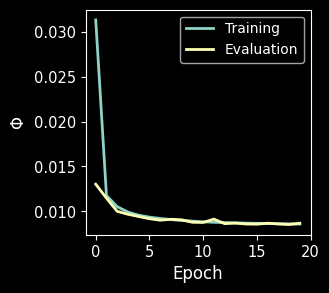

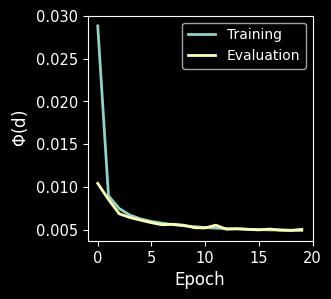

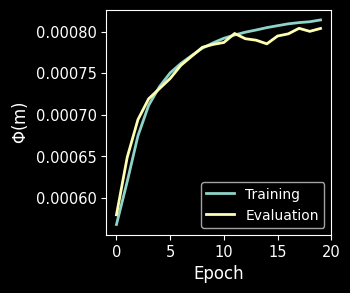

In [29]:
plot_loss(history)

### End